LP-based Shadow Ban Policy

# Clone and Install if Using Cluster

In [ ]:
!git clone https://github.com/zlisto/opinion_dynamics
import os
os.chdir("opinion_dynamics")

In [ ]:
!pip install control

# Import Packages

In [1]:
import numpy as np
import control.optimal as obc
import control as ct
from pyoptsparse import  Optimization, OPT
import pyoptsparse as pos
import scipy.sparse as sparse
from scipy.sparse import coo_matrix, csr_matrix, diags, identity

from scipy.optimize import linprog

import matplotlib.pyplot as plt
import scripts.shadowban_pyoptsparse as sb
from scripts.shadowban_adaptive import *
from scripts.opinion_visualization import *
from scripts.load_data import * # load Twitter network
from scripts.opinion_data import *
from scripts.dynamics_simulator import * # class for shadowban LP and RK simulation

# from scripts.class_dynamics import * # class for opinion dynamics simulation
import networkx as nx

import scipy.sparse as sp # save coo_matrix A and E in .npz
import pickle # save ndarray rates and opinions0 in .pkl

import pandas as pd
import time
import seaborn as sns
from datetime import datetime

import psutil # check CPU and memory usage

# Initialization

## Load Network

For your network `G` you need the following node features
   1. `rates` = array of posting rate of each node
   2. `opinions0` = array of initial opinions of each node

### Load Synthetic Network

In [ ]:
n0 = 20
nc = int(n0/2)
sizes = [nc, nc]
p0, p1 = 8/n0, 1/n0
probs = [[p0, p1], [p1, p0]]
G = nx.DiGraph(nx.stochastic_block_model(sizes, probs, seed=0))

for i in range(nc):
    rate = 1
    opinion0 = i/(nc-1)/2 
    opinion1 = 1-i/(nc-1)/2 
    G.nodes[i]['opinion'] = opinion0
    G.nodes[i+nc]['opinion'] = opinion1
    G.nodes[i]['rate'] = 1
    G.nodes[i+nc]['rate'] = 1
fig = draw_network(G)

A = nx.adjacency_matrix(G)
A = A.tocoo()
assert n0 == A.shape[0]  #number of nodes in network should equal shape of A
rates = np.array([G.nodes[v]["rate"] for v in G.nodes()])  #posting rates of nodes
opinions0 = np.array([G.nodes[v]["opinion"] for v in G.nodes()])  #initial opinions of nodes

plt.hist(opinions0)
plt.show()

E0 = nx.incidence_matrix(G,oriented=True)
E0 = E0.tocoo()
ind = E0.data>0
E = coo_matrix((E0.data[ind], (E0.row[ind], E0.col[ind])), E0.shape)  #incidence matrix with only tail of edge


network_params = {'A':A, 'rates':rates, 'opinions0':opinions0, 'E':E}
network_params['data_name'] = 'synthetic'

network_params

### (optional) Load Twitter Network

#### Specify network_name

In [ ]:
network_name = "data/GiletsJaunes_sample_02_agent"
# "Brexit_sample_02_agent"
# "GiletsJaunes_sample_02_agent" 
# "2016_Second_Presidential_Debate_random_sample" "2016_Second_Presidential_Debate_full"

#### (optional) Save coo_matrix A,E in .npz and others in .pkl

In [ ]:
G, network_params = G_to_params(network_name + ".csv")

# Save the adjacency matrix A
sp.save_npz(network_name + '_A.npz', network_params['A'])

# Save the incidence matrix E
sp.save_npz(network_name + '_E.npz', network_params['E'])

# Save rates
with open(network_name + '_rates.pkl', 'wb') as file:
    pickle.dump(network_params['rates'], file)

# Save opinions0
with open(network_name + '_opinions0.pkl', 'wb') as file:
    pickle.dump(network_params['opinions0'], file)

#### Reload network_params

In [ ]:
%%time
# Load the adjacency matrix A
A = sp.load_npz(network_name + '_A.npz')

# Load the incidence matrix E
E = sp.load_npz(network_name + '_E.npz')

# Load rates
with open(network_name + '_rates.pkl', 'rb') as file:
    rates = pickle.load(file)

# Load opinions0
with open(network_name + '_opinions0.pkl', 'rb') as file:
    opinions0 = pickle.load(file)

network_params = {'A':A, 'E':E, 'rates':rates, 'opinions0':opinions0}
G = nx.DiGraph(network_params['A'])


print(f"Number of nodes = {G.number_of_nodes()}")
print(f"Number of edges = {G.number_of_edges()}")
network_params

### Load US Election Full Data

Mean rate 0.09048739630394777 tweets/day
CPU times: user 8.83 s, sys: 541 ms, total: 9.37 s
Wall time: 9.62 s


{'A': <77563x77563 sparse matrix of type '<class 'numpy.float64'>'
 	with 5022773 stored elements in COOrdinate format>,
 'E': <77563x5022773 sparse matrix of type '<class 'numpy.float64'>'
 	with 5022773 stored elements in COOrdinate format>,
 'rates': array([0.01788376, 0.03874814, 0.0119225 , ..., 0.04172876, 0.00894188,
        1.21907601]),
 'opinions0': array([0.62639551, 0.33246811, 0.17944451, ..., 0.24893551, 0.39323948,
        0.23936598]),
 'data_name': 'US_election'}

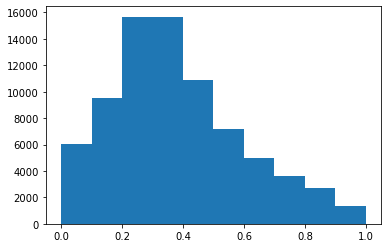

In [2]:
%%time
network_params = load_us_election()
network_params['data_name'] = 'US_election'
network_params['rates'] = network_params['rates']/11/30.5

plt.hist(network_params['opinions0'])
print(f"Mean rate {network_params['rates'].mean()} tweets/day")
network_params

### Load Gilets Jaunes Full Data

Mean rate 0.17397953996835083 tweets/day
CPU times: user 6.18 s, sys: 468 ms, total: 6.65 s
Wall time: 7.57 s


{'A': <41501x41501 sparse matrix of type '<class 'numpy.float64'>'
 	with 2257716 stored elements in COOrdinate format>,
 'E': <41501x2257716 sparse matrix of type '<class 'numpy.float64'>'
 	with 2257716 stored elements in COOrdinate format>,
 'rates': array([0.11922504, 0.05663189, 0.01490313, ..., 0.11922504, 0.50372578,
        0.70640835]),
 'opinions0': array([0.43113284, 0.41007323, 0.20396378, ..., 0.76298056, 0.71444237,
        0.11448741]),
 'data_name': 'giletsjaunes'}

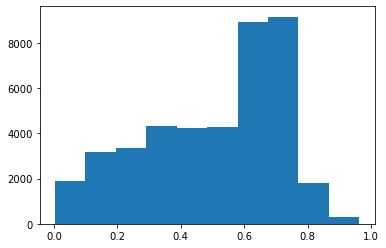

In [3]:
%%time
network_params = load_giletsjaunes()
network_params['data_name'] = 'giletsjaunes'

network_params['rates'] = network_params['rates']/11/30.5

plt.hist(network_params['opinions0'])
print(f"Mean rate {network_params['rates'].mean()} tweets/day")
network_params

## Set Simulation and Optimization Parameters

In [4]:
#simulation parameters
tau = 0.1
omega = 0.1

#shift function f
def shift(x):
    x = np.clip(x, -1, 1)
    y = omega *x*np.exp(-np.abs(x/tau)**2/2)
    
    return(y)

Tf = 180 #final time of simulator, days
npts_eval = 100 #number of time discretization points for simulation
npts = 3
assert npts < npts_eval

#for dynamics_simulator.py
control_steps = Tf
sim_steps = 3

#optimization parameters 
smax = 0.5  #max strength of shadow banning at any time
OBJECTIVE = 'MEAN'  #integral cost type
assert OBJECTIVE in ['MEAN','VARMIN','VARMAX','EXTRMIN']

## Create params Dictionary for Problem

In [4]:
additional_params = {'tau': tau, 'omega': omega, 'shift': shift, 
                     'Tf': Tf, 'npts_eval': npts_eval, 'npts': npts, 'control_steps': control_steps, 'sim_steps': sim_steps, 
                     'OBJECTIVE': OBJECTIVE, 'smax': smax}

params = {**network_params, **additional_params}
nv = params['A'].shape[0]
ne = params['E'].shape[1]

params

{'A': <77563x77563 sparse matrix of type '<class 'numpy.float64'>'
 	with 5022773 stored elements in COOrdinate format>,
 'E': <77563x5022773 sparse matrix of type '<class 'numpy.float64'>'
 	with 5022773 stored elements in COOrdinate format>,
 'rates': array([0.01788376, 0.03874814, 0.0119225 , ..., 0.04172876, 0.00894188,
        1.21907601]),
 'opinions0': array([0.62639551, 0.33246811, 0.17944451, ..., 0.24893551, 0.39323948,
        0.23936598]),
 'data_name': 'US_election',
 'tau': 0.1,
 'omega': 0.1,
 'shift': <function __main__.shift(x)>,
 'Tf': 180,
 'npts_eval': 100,
 'npts': 3,
 'control_steps': 180,
 'sim_steps': 3,
 'OBJECTIVE': 'MEAN',
 'smax': 0.5}

In [ ]:
# #if using certain optimization package:

# #names of edges for shadowbanning in format uij
# input_names = []
# for e in G.edges():
#     input_names.append(f"u{e[0]}{e[1]}")
# #names of nodes opinions in format thetai
# output_names = []
# for v in G.nodes():
#     output_names.append(f"theta{v}")

# additional_params = {'tau': tau, 'omega': omega, 'shift': shift, 
#                      'npts_eval': npts_eval, 'npts': npts, 'Tf': Tf, 'OBJECTIVE': OBJECTIVE, 'smax': smax}

# params = {**network_params, **additional_params}

# params

# (Not good) Simulate Using solve_ivp()

In [ ]:
#time derivative of opinions
def step_fast_opinion(opinions:np.ndarray, rates:list, A, tau:float, omega:float, 
                      U = None):
    n = len(rates)
    data = shift(opinions[A.row]- opinions[A.col],tau,omega) #shift value
    Shift_matrix = coo_matrix((data, (A.row, A.col)), shape=A.shape) 
    #scale rates on edges by shadow banning policy values
    if U != None:
        Shift_matrix = Shift_matrix.multiply(U)
        
    Rate_matrix = diags(rates,0) #create a diagonal matrix with Rates values

    D = Rate_matrix @ Shift_matrix # matrix multiply
    Dxdt = D.sum(axis = 0).A1 #contribution from following of node

    return Dxdt

#time derivative of opinions for odeint
def dxdt(t:float, opinions:np.ndarray, rates:list, A, tau:float, omega:float, U = None):    
    return step_fast_opinion(opinions, rates, A, tau, omega, U)

def sys_update(t, x, u, params):
    # Get the parameters for the model
    A = params.get('A')         # vehicle wheelbase
    rates = params.get('rates')
    tau = params.get('tau')
    omega = params.get('omega')
    
    
    # Create COO matrix U with data from u at A's locations
    
    U_row = A.row
    U_col = A.col
    U = coo_matrix((u, (U_row, U_col)), shape=(A.shape[0], A.shape[1]))

    # Return the derivative of the state
    return dxdt(t, x, rates, A, tau, omega, U)

In [ ]:
%%time

from scipy.integrate import solve_ivp

# dxdt = sys_update_lp_ivp
# dxdt = sys_update


# npts_eval = 100
t_eval = np.linspace(0, Tf, Tf*2)

u = np.ones(ne) #dummy
args = (u,params)


sol = solve_ivp(fun=sys_update, t_span=[0, Tf], y0=params['opinions0'], method='Radau', 
                t_eval=t_eval, args=args, dense_output=True)

Opinions_lp = sol.y

obj_lp = sb.cost_sim(OBJECTIVE, Opinions_lp)

fig = plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
# plot_opinion_quantiles(t_eval, Opinions_lp)
plot_opinions(t_eval,Opinions_lp.T)
# plt.ylim(0, 1)
plt.title(f"{nv} nodes LP Shadow Ban {OBJECTIVE} = {obj_lp:.3f}")

plt.plot(sol.y.T)
plt.xlabel('t')
plt.ylim(0, 1)
plt.show()

# Simulate Using Control Package

## Define Input/Output Systems

In [ ]:
sys_no_agent = ct.NonlinearIOSystem(
        updfcn =sb.sys_update, outfcn= None, states=nv,
        inputs=ne, outputs = nv,
        name='shadowban network no agent', params=params)

sys_lp = ct.NonlinearIOSystem(
        updfcn =sys_update_lp, outfcn= None, states=nv,
        inputs=ne, outputs = nv,
        name='shadowban network lp', params=params)

## Opinions with no Shadow Banning

In [ ]:
%%time
T, Opinions_no_agent, _ = sb.simulate_opinions(params, sys_no_agent)
obj_no_agent = sb.cost_sim(OBJECTIVE, Opinions_no_agent)

print(f"Objective with no SB = {obj_no_agent}")

## Opinions with LP Adaptive Shadow Banning

In [ ]:
%%time

for OBJECTIVE in ['MEAN','VARMIN','VARMAX']:
# for OBJECTIVE in ['MEAN']:
    params['OBJECTIVE'] = OBJECTIVE
    obj_no_agent = sb.cost_sim(OBJECTIVE, Opinions_no_agent)
    #LP shadow banning 
    T, Opinions_lp, _ = sb.simulate_opinions(params, sys_lp)
    obj_lp = sb.cost_sim(OBJECTIVE, Opinions_lp)

    fig = plt.figure(figsize = (10,4))
    plt.subplot(1,2,1)
    # plot_opinion_quantiles(T, Opinions_no_agent)
    plot_opinions(T, Opinions_no_agent)
    plt.ylim(0, 1)
    plt.title(f"{nv} nodes {OBJECTIVE} = {obj_no_agent:.3f}")

    plt.subplot(1,2,2)
    # plot_opinion_quantiles(T, Opinions_lp)
    plot_opinions(T, Opinions_lp)
    plt.ylim(0, 1)
    plt.title(f"{nv} nodes LP Shadow Ban {OBJECTIVE} = {obj_lp:.3f}")
    
    # plt.savefig(f"results/shadowban_{OBJECTIVE}_{nv}_node_sbm.jpeg")

    plt.show()

# Simulate Using dynamics_simulator.py

1. Optimize control by LP for `control_steps` control intervals
2. Solve state ivp by RK for `sim_steps` within each control interval

Took 32.199547064304355 mins to simulate no ban.
Took 97.93137981494267 mins to simulate ban MEAN.


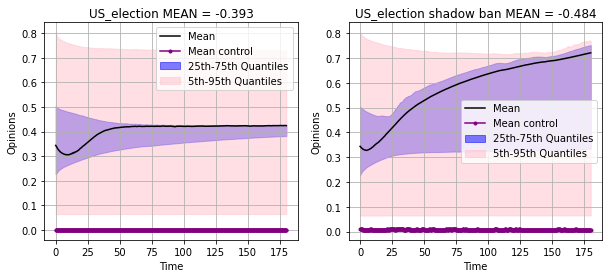

Memory usage: 3562.82368 mega bytes
CPU usage: 52.1 %
CPU times: user 1h 8min 46s, sys: 18min 1s, total: 1h 26min 48s
Wall time: 1h 40min 34s


In [5]:
%%time

start_time = time.time()
# environment for no shadow banning
env_no_ban = OpinionSimulatorContinuous(params, False)
Opinions_no_ban, Controls_no_ban = opinion_simulation(env_no_ban)

print(f"Took {(time.time()-start_time)/60} mins to simulate no ban.")

T = np.linspace(0, Tf, sim_steps*control_steps + 1)

# for OBJECTIVE in ['VARMIN']:
# for OBJECTIVE in ['VARMAX']:
for OBJECTIVE in ['MEAN']:
    params['OBJECTIVE'] = OBJECTIVE
    
    # objective value of no ban
    obj_no_ban = cost_sim(OBJECTIVE, Opinions_no_ban, Controls_no_ban)
    
    # environment for shadow banning
    env_ban = OpinionSimulatorContinuous(params, True)
    Opinions_ban, Controls_ban = opinion_simulation(env_ban)
    obj_ban = cost_sim(OBJECTIVE, Opinions_ban, Controls_ban)
    
    print(f"Took {(time.time()-start_time)/60} mins to simulate ban {OBJECTIVE}.")

    # Plot
    fig = plt.figure(figsize = (10,4))

    plt.subplot(1,2,1)
    plot_opinion_quantiles(T, Opinions_no_ban, U=Controls_no_ban)
    # plot_opinions(T, Opinions_no_ban)
    # plt.ylim(0, 1)
    plt.title(f"{params['data_name']} {OBJECTIVE} = {obj_no_ban:.3f}")

    plt.subplot(1,2,2)
    plot_opinion_quantiles(T, Opinions_ban, U=Controls_ban)
    # plot_opinions(T, Opinions_ban)
    # plt.ylim(0, 1)
    plt.title(f"{params['data_name']} shadow ban {OBJECTIVE} = {obj_ban:.3f}")
    
    plt.savefig(f"results/{params['data_name']}/{params['data_name']}_{OBJECTIVE}_{nv}_node.jpeg")
    
    plt.show()
    
# Get memory usage
memory = psutil.virtual_memory()
print("Memory usage:", memory.used/10**6, "mega bytes")

# Get CPU usage
cpu_percent = psutil.cpu_percent(interval=10)
print("CPU usage:", cpu_percent, "%")

In [6]:
%%time

#get data only at control points
Controls_no_ban_desize = Controls_no_ban[]

np.savez(f"results/{params['data_name']}/{params['data_name']}_noban_{OBJECTIVE}_{nv}_node.npz", 
         obj_no_ban=obj_no_ban, Opinions_no_ban=Opinions_no_ban, Controls_no_ban_desize=Controls_no_ban_desize)

np.savez(f"results/{params['data_name']}/{params['data_name']}_shadowban_{OBJECTIVE}_{nv}_node.npz", 
         obj_ban=obj_ban, Opinions_ban=Opinions_ban, Controls_ban_desize=Controls_ban_desize)

CPU times: user 1min 3s, sys: 1min 18s, total: 2min 21s
Wall time: 3min 44s


In [14]:
from scipy.stats import gaussian_kde

def plot_opinion_heatmap(T,Opinions, cmap = 'jet'):
    yopinions = np.linspace(0,1,100)
    Z = []
    XT = []
    Yopinions = []
    for tind in range(Opinions.shape[0]):
        kde = gaussian_kde(Opinions[tind,:])
        Z.append(kde(yopinions))
        XT.append(T[tind]*np.ones(len(T)))
        Yopinions.append(yopinions)

    plt.pcolormesh(XT, Yopinions, Z, cmap= cmap)
    plt.colorbar()
    return XT,Yopinions,Z

In [ ]:
#plot opinion heatmap
plt.figure(figsize = (16,4))
plt.subplot(1,2,1)
plot_opinion_heatmap(T, Opinions_ban,'jet')
plt.title(f"No shadow banning: {OBJECTIVE} = {obj_ban:.3f}")
plt.ylim([0,1])

# plt.subplot(1,2,2)
# plot_opinion_heatmap(T,Opinions_best, 'jet')
# plt.title(f"Shadow banning: {OBJECTIVE} = {obj_best:.3f}")
# plt.ylim([0,1])

plt.show()

In [ ]:
%%time

#Plot opinions
fig = plt.figure(figsize = (10,4))

plt.subplot(1,2,1)
# plot_opinion_quantiles(T, Opinions_no_ban)
plot_opinions(T, Opinions_no_ban)
# plt.ylim(0, 1)
plt.title(f"{nv} nodes {OBJECTIVE} = {obj_no_ban:.3f}")

plt.subplot(1,2,2)
# plot_opinion_quantiles(T, Opinions_ban)
plot_opinions(T, Opinions_ban)
# plt.ylim(0, 1)
plt.title(f"{nv} nodes LP Shadow Ban {OBJECTIVE} = {obj_ban:.3f}")

# Analyze Results

In [3]:
%%time
import numpy as np
results_no_ban = np.load('results/US_election/US_election_noban_MEAN_77563_node.npz')
obj_no_ban = results_no_ban['obj_no_ban']
Opinions_no_ban = results_no_ban['Opinions_no_ban']
Controls_no_ban = results_no_ban['Controls_no_ban']

results_ban = np.load('results/US_election/US_election_shadowban_MEAN_77563_node.npz')
obj_ban = results_ban['obj_ban']
Opinions_ban = results_ban['Opinions_ban']
Controls_ban = results_ban['Controls_ban']

CPU times: user 55.1 s, sys: 36.8 s, total: 1min 31s
Wall time: 2min 3s


In [26]:
mean_control = np.mean(Controls_ban, axis=1) # Calculate the mean value along the second axis
max_control = np.max(Controls_ban, axis=1)
min_control = np.min(Controls_ban, axis=1)

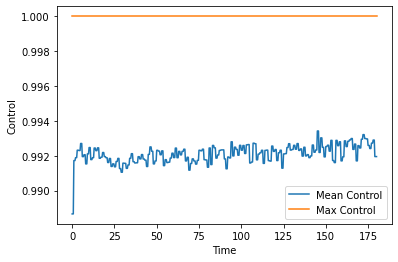

In [27]:
T = np.linspace(0,Tf,mean_control.shape[0])

plt.plot(T, mean_control, label='Mean Control')
plt.plot(T, max_control, label='Max Control')
# plt.plot(T, min_control, label='Min Control')

plt.xlabel('Time')
plt.ylabel('Control')
plt.legend()
plt.show()

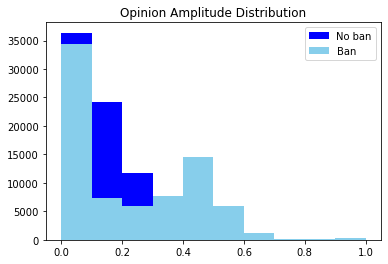

In [8]:
import matplotlib.pyplot as plt
# Check oscillation
Opinions_max_no_ban = np.max(Opinions_no_ban, axis=0)
Opinions_min_no_ban = np.min(Opinions_no_ban, axis=0)
Opinions_amplitude_no_ban = Opinions_max_no_ban - Opinions_min_no_ban

Opinions_max_ban = np.max(Opinions_ban, axis=0)
Opinions_min_ban = np.min(Opinions_ban, axis=0)
Opinions_amplitude_ban = Opinions_max_ban - Opinions_min_ban

plt.hist(Opinions_amplitude_no_ban, label='No ban', color='blue')
plt.hist(Opinions_amplitude_ban, label='Ban', color='skyblue')

plt.title('Opinion Amplitude Distribution')
plt.legend()
plt.show()

In [ ]:
# FFT